Tutorial on computational modeling and statistical model fitting as a part the *Trends in Computational Neuroscience* graduate course of the University of Geneva (March-April 2020). **Lecturer:** [Luigi Acerbi](http://luigiacerbi.com/).

**Instructions:** 
- To run the tutorial, you will need a standard scientific Python 3.x installation with Jupyter notebook (such as [Anaconda](https://www.anaconda.com/distribution/)). 
- You will also need the `CMA-ES` optimization algorithm (see [here](https://github.com/CMA-ES/pycma)). You can install CMA-ES from the command line with `pip install cma`.
- For any question, please email the course instructor at luigi.acerbi@unige.ch.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import norm
import cma

During this tutorial, we are going to use data from the [International Brain Laboratory](https://www.internationalbrainlab.com/) publicly released behavioral mouse dataset, from exemplar mouse `KS014`. See [this preprint](https://www.biorxiv.org/content/10.1101/2020.01.17.909838v2) for more information about the task and datasets. These data can also be inspected via the IBL DataJoint public interface [here](https://data.internationalbrainlab.org/mouse/18a54f60-534b-4ed5-8bda-b434079b8ab8).

For convenience, the data of all behavioral sessions from examplar mouse `KS014` have been already downloaded in the `data` folder and slightly preprocessed into two `.csv` files, one for the training sessions (`KS014_train.csv`) and one with the *biased* sessions (`KS014_biased.csv`). 

We begin our tutorial by examining the training sessions. 

In [2]:
df = pd.read_csv('./data/KS014_train.csv')                     # Load .csv file into a pandas DataFrame
df['signed_contrast'] = df['contrast']*df['position']   # We define a new column for "signed contrasts"
df.drop(columns='stim_probability_left', inplace=True)  # Stimulus probability has no meaning for training sessions

print('Total # of trials: ' + str(len(df['trial_num'])))
print('Sessions: ' + str(np.unique(df['session_num'])))
df.head()

Total # of trials: 10310
Sessions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


,trial_num,session_num,contrast,position,response_choice,trial_correct,reaction_time,signed_contrast
0,1,1,100.0,-1.0,-1,1.0,1.052300,-100.0
1,2,1,50.0,1.0,1,1.0,0.276001,50.0
2,3,1,50.0,1.0,-1,0.0,2.094101,50.0
3,4,1,50.0,-1.0,1,0.0,3.407901,-50.0
4,5,1,50.0,1.0,1,1.0,1.601400,50.0


**Inspecting the data:**

The first thing to do with any dataset is to get familiar with it by running simple visualizations. Just plot stuff!
For example, as a starter we plot data from individual sessions using a *scatterplot* format (perhaps not the best). What can we see from here?

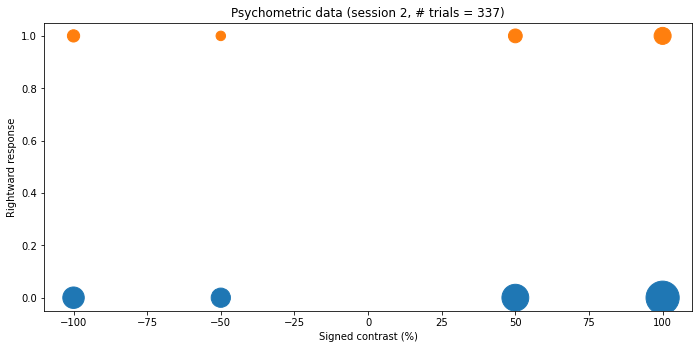

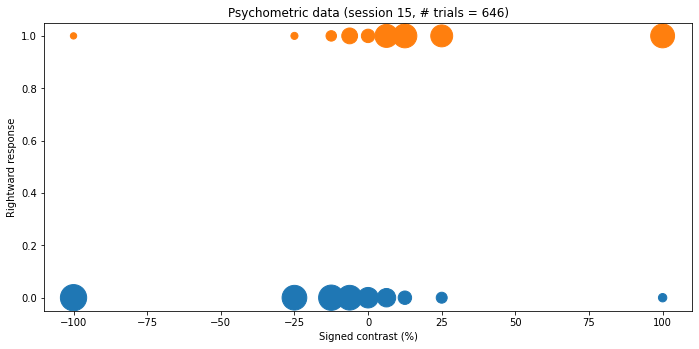

In [3]:
def scatterplot_psychometric_data(df,session_num,ax=None):
    """Plot psychometric data of a chosen training session as a scatter plot."""
    session_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(df['session_num'] == session_num) # Number of trials for the chosen session
    
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & session_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & session_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.scatter(left_resp.index,np.zeros(len(left_resp.index)), s=left_resp*10);
    ax.scatter(right_resp.index,np.ones(len(right_resp.index)), s=right_resp*10);
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    return ax

# Plot 2nd session
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,2)
plt.show()

# Plot 15th session (last training session)
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,15)
plt.show()


We plot the same data again, this time with a different type of plot which may be more informative.

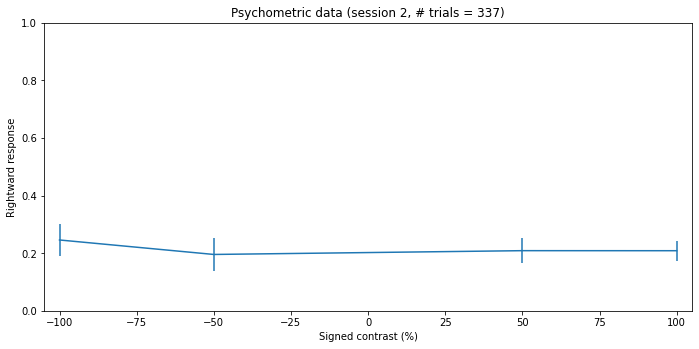

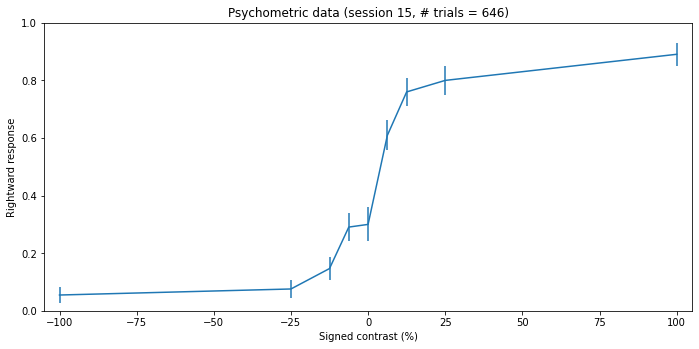

In [4]:
def plot_psychometric_data(df,session_num,ax=None):
    """Plot psychometric data of a chosen training session as a scatter plot."""
    session_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(df['session_num'] == session_num) # Number of trials for the chosen session
    
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & session_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & session_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    frac_resp = right_resp / (left_resp + right_resp)
    err_bar = np.sqrt(frac_resp*(1-frac_resp)/(left_resp + right_resp)) # Why this formula for error bars?
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.errorbar(x=left_resp.index,y=frac_resp,yerr=err_bar,label='data');
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')
    plt.xlim((-105,105))
    plt.ylim((0,1))
    return ax

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,2)
plt.show()

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,15)
plt.show()

We define now the psychometric function (descriptive) model and a plotting function.

In [5]:
def psychofun(theta,stim):
    """Psychometric function based on normal CDF and lapses"""
    mu = theta[0]          # bias
    sigma = theta[1]       # slope/noise
    lapse = theta[2]       # lapse rate
    if len(theta) == 4:    # lapse bias
        lapse_bias = theta[3];
    else:
        lapse_bias = 0.5   # if theta has only three elements, assume symmetric lapses
    
    p_right = norm.cdf(stim,loc=mu,scale=sigma)    # Probability of responding "rightwards", without lapses
    p_right = lapse*lapse_bias + (1-lapse)*p_right # Adding lapses

    return p_right

def psychofun_plot(theta,ax):
    """Plot psychometric function"""    
    stim = np.linspace(-100,100,201)   # Create stimulus grid for plotting    
    p_right = psychofun(theta,stim)    # Compute psychometric function values
    ax.plot(stim,p_right,label='model')
    ax.legend()
    return

Now try plotting the psychometric function for different values of the parameters (use both the symmetric and asymmetric psychometric function). Try and match the data from one of the sessions.

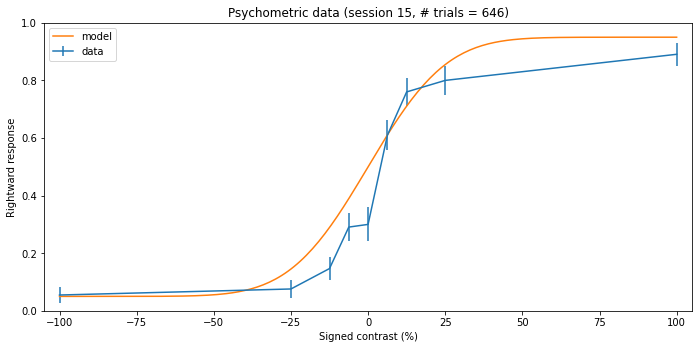

In [6]:
theta0 = (0,20,0.1,0.5) # Arbitrary parameter values - try different ones
fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df,15)
psychofun_plot(theta0,ax)
plt.show()

We now define the log likelihood function of the psychometric function model for a given dataset and model parameter vector, $\log p(\text{data}|\mathbf{\theta})$.

In [7]:
def psychofun_loglike(theta,df):
    """Log-likelihood for psychometric function model"""
    s_vec = df['signed_contrast'] # Stimulus values
    r_vec = df['response_choice']  # Responses
    
    p_right = psychofun(theta,s_vec)
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

Now try to get the best fit for this session, as we did before, but by finding better and better values of the log-likelihood.

Log-likelihood value: -315.501


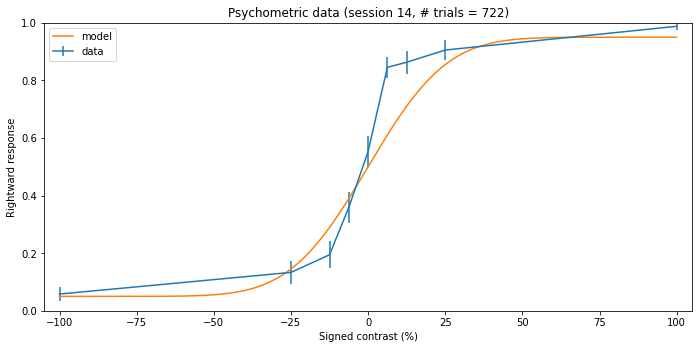

In [8]:
session_num = 14 # Let's use a different session

theta0 = (0,20,0.1,0.5) 

ll = psychofun_loglike(theta0,df[df['session_num'] == session_num])
print('Log-likelihood value: ' + "{:.3f}".format(ll))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df,session_num)
psychofun_plot(theta0,ax)
plt.show()

Let's switch now to maximum-likelihood estimation via *optimization*. 
We are going to *minimize* the negative log-likelihood using a black-box optimization algorithm called CMA-ES.

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=865893, Wed Apr  1 10:13:24 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.230282021340386e+02 1.0e+00 4.74e-01  4e-01  5e-01 0:00.0
    2     16 3.345009850755669e+02 1.5e+00 4.62e-01  4e-01  5e-01 0:00.0
    3     24 3.156112423967703e+02 1.6e+00 5.41e-01  4e-01  6e-01 0:00.0
  100    800 3.076344953638911e+02 1.0e+02 2.32e-03  1e-05  7e-04 0:00.9
  107    856 3.076344953352777e+02 7.4e+01 1.08e-03  5e-06  2e-04 0:01.0
termination on tolfun=1e-05 (Wed Apr  1 10:13:25 2020)
final/bestever f-value = 3.076345e+02 3.076345e+02
incumbent solution: [1.862288841885919, 11.513380238332283, 0.19464477533924657, 0.3150597489987131]
std deviation: [0.00014936188536497842, 0.00021480515137116984, 4.965539787457603e-06, 8.744828528228324e-06]

Returned parameter vector: [ 1.86228884 11.51338024  0.19464478  0.31505975]
Negative log-likelihood at solution: 307.6344953327027


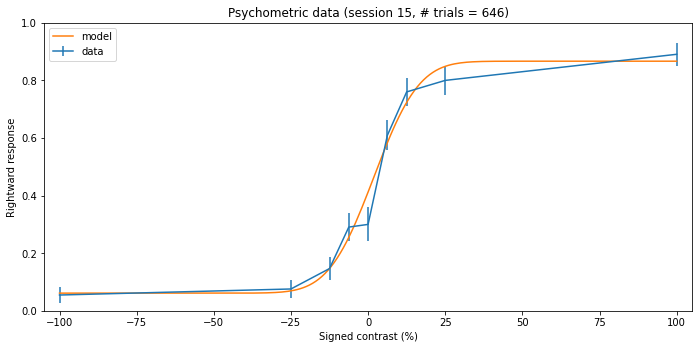

In [9]:
# Define parameter bounds
lb = np.array([-100,1,0,0])
ub = np.array([100,100,1,1])
bounds = [lb,ub]

session_num = 15
theta0 = (0,20,0.1,0.5) # Starting point for the optimization

df_session = df[df['session_num'] == session_num]
opt_fun = lambda theta_: -psychofun_loglike(theta_,df_session) # Define objective function: negative log-likelihood

opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)
res = cma.fmin(opt_fun, theta0, 0.5, opts)

print('')
print('Returned parameter vector: ' + str(res[0]))
print('Negative log-likelihood at solution: ' + str(res[1]))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_session,session_num)
psychofun_plot(res[0],ax)
plt.show()


**Optional:** We consider next a more advanced model which includes time dependency (the trials are not all the same).

In [10]:
def psychofun_timevarying_loglike(theta,df):
    """Log-likelihood for time-varying psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses
    
    Ntrials = len(s_vec)
    mu_vec = np.linspace(theta[0],theta[4],Ntrials)
    sigma_vec = np.linspace(theta[1],theta[5],Ntrials)
    lapse_vec = np.linspace(theta[2],theta[6],Ntrials)
    lapsebias_vec = np.linspace(theta[3],theta[7],Ntrials)
    
    p_right = np.zeros(Ntrials)
    
    for t in range(0,Ntrials):
        p_right[t] = psychofun([mu_vec[t],sigma_vec[t],lapse_vec[t],lapsebias_vec[t]],s_vec[t])
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

theta0 = (0,20,0.1,0.5,1,20,0.1,0.5)
ll = psychofun_timevarying_loglike(theta0,df[df['session_num'] == session_num])


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=841059, Wed Apr  1 10:13:26 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.219013792046053e+02 1.0e+00 4.89e-01  5e-01  5e-01 0:00.8
    2     20 3.185990174844539e+02 1.3e+00 4.76e-01  4e-01  5e-01 0:01.6
    3     30 3.197083903162443e+02 1.4e+00 4.58e-01  4e-01  5e-01 0:02.4
    7     70 3.209273631010846e+02 1.7e+00 3.44e-01  3e-01  4e-01 0:05.4
   13    130 3.149731583840938e+02 2.0e+00 2.27e-01  2e-01  3e-01 0:09.7
   20    200 3.126787994775112e+02 2.2e+00 1.66e-01  1e-01  2e-01 0:15.1
   28    280 3.116434034991303e+02 2.7e+00 1.58e-01  9e-02  2e-01 0:21.2
   37    370 3.112837607692519e+02 3.5e+00 7.94e-02  3e-02  9e-02 0:28.8
   46    460 3.108041641917678e+02 5.3e+00 7.67e-02  3e-02  9e-02 0:37.3
   60    600 3.093607024175189e+02 1.4e+01 1.30e-01  3e-02  2e-01 0:46.7
   76    760 3.012053362709289e+02 3.6e+01 5.16e-01  1e-01  1e+00 0:57.0
   93    930 2.972512918604086e+02

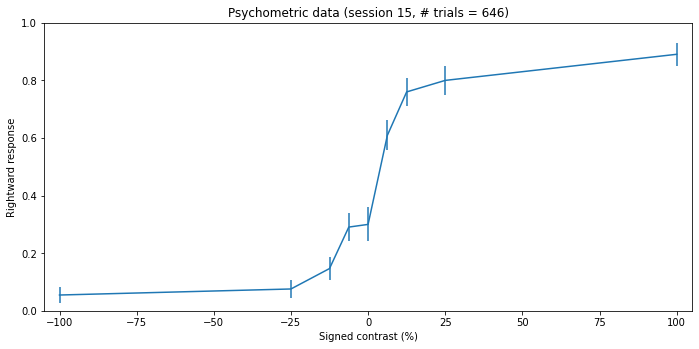

In [11]:
lb = np.array([-100,1,0,0,-100,1,0,0])
ub = np.array([100,100,1,1,100,100,1,1])
bounds = [lb,ub]

session_num = 15

df_session = df[df['session_num'] == session_num]
# df_session = df[(df['session_num'] == session_num) & (df['trial_num'] < 300)]

opt_fun = lambda theta_: -psychofun_timevarying_loglike(theta_,df_session)

opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)
res = cma.fmin(opt_fun, theta0, 0.5, opts)

print('')
print('Returned parameter vector: ' + str(res[0]))
print('Negative log-likelihood at solution: ' + str(res[1]))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_session,session_num)
#psychofun_plot(res[0],ax)
plt.show()